Project step overview

In [2]:
## imports
import numpy as np
import networkx as nx
import scipy.stats as stats
import pandas as pd
import sklearn as sk
import itertools
import os
from bed_reader import open_bed
from IPython.display import SVG
from sknetwork.embedding import LouvainNE
from sknetwork.embedding import LouvainEmbedding
from sknetwork.visualization import svg_graph, svg_bigraph
from networkx.algorithms import bipartite
from networkx.algorithms import community
from scipy import sparse
from sknetwork.hierarchy import LouvainHierarchy
from sknetwork.hierarchy import cut_straight, dasgupta_score, tree_sampling_divergence
from sknetwork.visualization import svg_graph, svg_bigraph, svg_dendrogram
from sklearn.neighbors import NearestNeighbors
from scipy.stats import chi2_contingency
from scipy.sparse import diags

In [3]:
def get_diagonal(df, width) : # convert SNPxSNP matrix as a result of cramer's to diagonal
    mid = df[df.shape(0)]
    arr = []
    result = np.empty(arr)
    for i in df:
        for j in df.T:
            if abs((i - j)) > width:
                result.append(j)

    return result

In [4]:
## get database workspace
file_name = '/Users/rishasurana/Library/CloudStorage/GoogleDrive-rsurana@usc.edu/.shortcut-targets-by-id/1I-Ssaub3M29w33JyrvO7HVv9laffGidc/chromosome_17_bed_bim_fam_data/ukb22418_c13_b0_v2.bed'
## read bed and select values
bed = open_bed(file_name)
print(bed.shape)
values = bed.read(index=np.s_[0:71,0:71])
print(values.shape)
values = np.array(values)

(488377, 26806)
(71, 71)


SAMPLE build Cramer's correlation matrix
note: Do not use, use SNPcorrelation.ipynb

In [5]:
def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  
  return stat/(obs*mini)

In [57]:
import warnings ## temporarily hide NaN division warnings
warnings.filterwarnings("ignore")

rows= []

for var1 in values:
  col = []
  for var2 in values.T:
    cramers =cramers_V(var1, var2) # Cramer's V test
    col.append(round(cramers,5)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results)

df.columns = labels
df.index = labels

df

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
0,0.00410,NaN,0.07245,0.03301,0.01763,0.00351,0.01791,NaN,0.00869,0.03997,...,0.02253,0.19683,0.02085,0.06355,0.09404,0.02995,0.02908,NaN,0.02873,0.00152
1,0.00485,NaN,0.12218,0.00624,0.05698,0.06750,0.03701,NaN,0.00078,0.01966,...,0.02470,0.07442,0.02363,0.15459,0.03649,0.06504,0.04043,NaN,0.00563,0.01301
2,0.00342,NaN,0.01167,0.01096,0.15586,0.23988,0.05683,NaN,0.03755,0.02338,...,0.00995,0.11269,0.01525,0.00540,0.07184,0.04365,0.01763,NaN,0.05460,0.01469
3,0.03105,NaN,0.00921,0.01096,0.10525,0.13055,0.04941,NaN,0.03386,0.09819,...,0.08927,0.11739,0.01109,0.07773,0.06685,0.05503,0.02025,NaN,0.03827,0.01690
4,0.00768,NaN,0.03328,0.00522,0.04156,0.07173,0.02083,NaN,0.00622,0.02024,...,0.03046,0.04828,0.01526,0.02962,0.03952,0.01692,0.00810,NaN,0.02001,0.03024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,0.00606,NaN,0.02012,0.01176,0.06611,0.08604,0.04918,NaN,0.03678,0.05396,...,0.03052,0.07886,0.04274,0.00621,0.04267,0.07180,0.01576,NaN,0.02418,0.02234
67,0.01848,NaN,0.03283,0.01535,0.08355,0.15807,0.02195,NaN,0.02027,0.00288,...,0.00355,0.09510,0.00537,0.00756,0.05430,0.03526,0.01095,NaN,0.08510,0.00845
68,0.00419,NaN,0.06726,0.02069,0.08461,0.16859,0.06391,NaN,0.00026,0.02473,...,0.02780,0.13700,0.01246,0.06355,0.04241,0.02032,0.00584,NaN,0.01826,0.00261
69,0.01005,NaN,0.06252,0.06863,0.04591,0.04316,0.02645,NaN,0.03393,0.05793,...,0.02707,0.04922,0.03168,0.18841,0.05928,0.02484,0.06442,NaN,0.00609,0.01309


In [7]:
from scipy.sparse import *
def iter_spmatrix(matrix):
    """ Iterator for iterating the elements in a ``scipy.sparse.*_matrix`` 

    This will always return:
    >>> (row, column, matrix-element)

    Currently this can iterate `coo`, `csc`, `lil` and `csr`, others may easily be added.

    Parameters
    ----------
    matrix : ``scipy.sparse.sp_matrix``
      the sparse matrix to iterate non-zero elements
    """
    if isspmatrix_coo(matrix):
        print("1")
        for r, c, m in zip(matrix.row, matrix.col, matrix.data):
            yield r, c, m

    elif isspmatrix_csc(matrix):
        print("2")
        for c in range(matrix.shape[1]):
            for ind in range(matrix.indptr[c], matrix.indptr[c+1]):
                yield matrix.indices[ind], c, matrix.data[ind]

    elif isspmatrix_csr(matrix):
        print("3")
        for r in range(matrix.shape[0]):
            for ind in range(matrix.indptr[r], matrix.indptr[r+1]):
                yield r, matrix.indices[ind], matrix.data[ind]

    elif isspmatrix_lil(matrix):
        print("4")
        for r in range(matrix.shape[0]):
            for c, d in zip(matrix.rows[r], matrix.data[r]):
                yield r, c, d

    else:
        raise NotImplementedError("The iterator for this sparse matrix has not been implemented")

In [75]:
# binarize
dfSparse = sparse.csr_matrix(df) # convert data frame to a sparse matrix
for i in range(np.shape(dfMatrix)[0]):
    for j in range(np.shape(dfMatrix)[1]):
        if dfSparse[i,j] <= 0.3:
            dfSparse[i,j] = 0
        else:
            dfSparse[i,j] = 1

dfSparse

<71x71 sparse matrix of type '<class 'numpy.float64'>'
	with 5041 stored elements in Compressed Sparse Row format>

In [80]:
dfMatrix = dfSparse.toarray()
dfMatrix.shape

(71, 71)

Build graph

In [83]:
# get triangle
triangle = np.triu(dfMatrix, k=1) # get upper half
print(triangle)
print(triangle.shape)
triangleSparse = sparse.csr_matrix(triangle)

[[0. 1. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(71, 71)


71


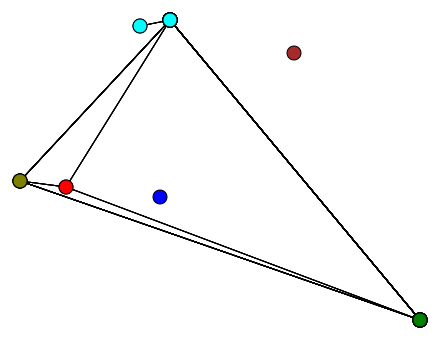

In [85]:
# create adjacency matrix 
G = nx.Graph(triangleSparse) # create graph from sparse data [UPDATE THIS]
adjacency = nx.adjacency_matrix(G) # create Adjacency matrix
adjacencyMatrix = sparse.csr_matrix(adjacency) # convert array to sparse row matrix form
print(adjacencyMatrix.shape[0])

## train classifier and build graph
louvain = LouvainNE(2)
embedding = louvain.fit_transform(adjacencyMatrix)
degrees = adjacency.dot(np.ones(adjacency.shape[0]))

labels = []
for i in range(adjacencyMatrix.shape[0]):
    labels.append(i)

image = svg_graph(adjacencyMatrix, position=embedding, display_edge_weight= True, display_node_weight=False, labels=labels)

#show graph
SVG(image)
